In [1]:
import argparse
import os
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import cv2
import numpy as np
import torch
import imageio
import matplotlib.pyplot as plt
import sys
import matplotlib.cm as cm
import kornia as K
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
densematching_path = "/home/jireh/MT/video_sychronazation/DenseMatching"
if densematching_path not in sys.path:
    sys.path.append(densematching_path)
if torch.cuda.is_available():
    device = 'cuda'
else:
    raise RuntimeError("GPU is required to run this demo.")

In [2]:
from model_selection import model_type, pre_trained_model_types, select_model
# from datasets.util import pad_to_same_shape
from utils_flow.img_processing_utils import pad_to_same_shape
torch.set_grad_enabled(False)
from utils_flow.pixel_wise_mapping import remap_using_flow_fields
from utils_flow.visualization_utils import overlay_semantic_mask, make_sparse_matching_plot
from utils_flow.util_optical_flow import flow_to_image  
from models.inference_utils import estimate_mask
from utils_flow.flow_and_mapping_operations import convert_flow_to_mapping
from validation.utils import matches_from_flow
from admin.stats import DotDict 
from model_selection import select_model
from utils_flow.visualization_utils import overlay_semantic_mask
from utils_flow.pixel_wise_mapping import remap_using_flow_fields
from demos.utils import (AverageTimer, VideoStreamer, make_matching_and_warping_plot_fast, make_matching_plot_fast)
from validation.test_parser import define_model_parser
from utils_flow.visualization_utils import make_and_save_video

%matplotlib inline

Did not load moviepy


## Load video frames

==> Processing video input: /home/jireh/MT/data/hdVideos/hd_00_01.mp4
==> Processing video input: /home/jireh/MT/data/hdVideos/hd_00_04.mp4


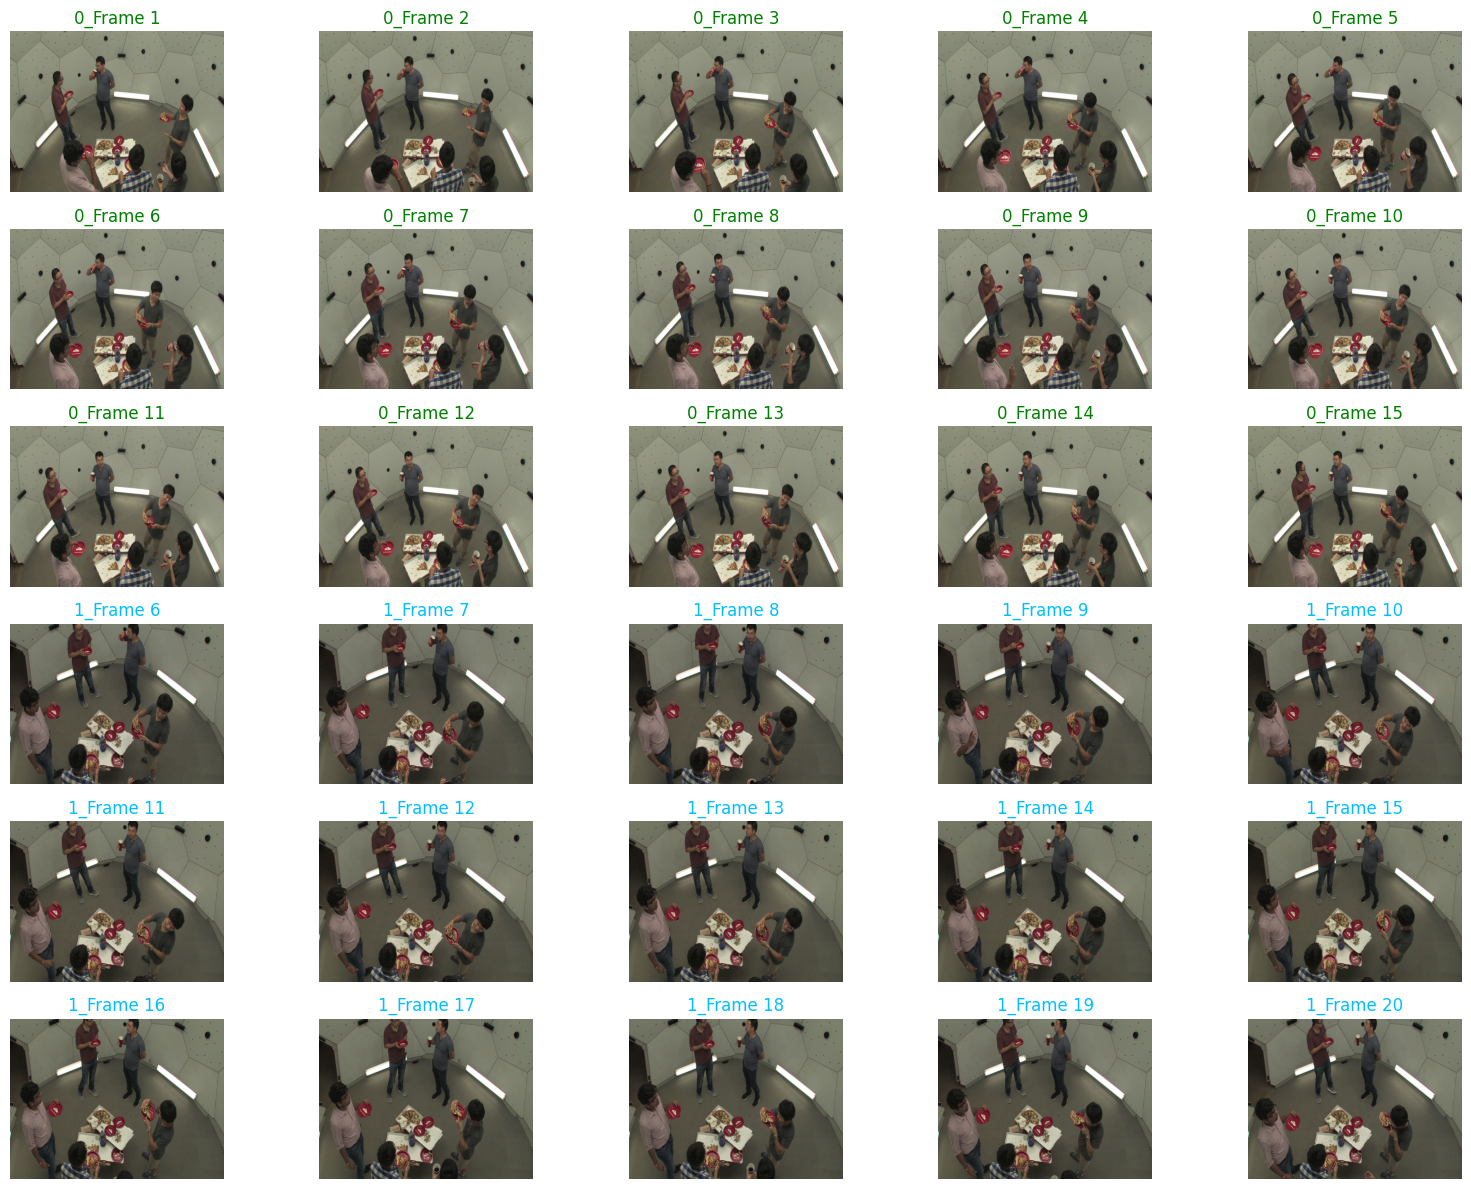

In [3]:
video_input0 = "/home/jireh/MT/data/hdVideos/hd_00_01.mp4"
video_input1 = "/home/jireh/MT/data/hdVideos/hd_00_04.mp4"
resize=[640, 480]
skip=15
image_glob=['*.png', '*.jpg', '*.jpeg']
max_length=1000000

vs0 = VideoStreamer(video_input0, resize, skip, image_glob, max_length)
vs1 = VideoStreamer(video_input1, resize, skip, image_glob, max_length)

fig,axes = plt.subplots(6,5,figsize = (16,12))
for _ in range(155):
    frame0, ret0 = vs0.next_frame()
    frame1, ret1 = vs1.next_frame()
    
frame_set0 = []
frame_set1 = []
for i in range(3):
    for j in range(5):
        frame, ret = vs0.next_frame()
        assert ret, 'Error when reading the first frame (try different --input?)'
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        axes[i,j].imshow(frame)
        axes[i, j].axis('off')  
        axes[i, j].set_title(f"0_Frame {i*5+j+1}",color='green')
        frame_set0.append(frame)

#video1 shift 5 frames
for _ in range(5):
    frame, ret = vs1.next_frame()

for i in range(3):
    for j in range(5):
        frame, ret = vs1.next_frame()
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        assert ret, 'Error when reading the first frame (try different --input?)'
        axes[i+3,j].imshow(frame)
        axes[i+3, j].axis('off')  
        axes[i+3, j].set_title(f"1_Frame {i*5+j+6}",color='deepskyblue')
        frame_set1.append(frame)

plt.tight_layout()
plt.savefig("Frame.png")
plt.show()

## Background mask

In [4]:
import cv2
import numpy as np
import os
import sys
from utils.samples.coco import coco
from mrcnn import utils
from mrcnn import model as modellib
from mrcnn import visualize
import matplotlib.pyplot as plt
import PIL.Image
import sys

# COCO Class names
# Index of the class in the list is its ID. For example, to get ID of
# the teddy bear class, use: class_names.index('teddy bear')
class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']

Using TensorFlow backend.


In [5]:
def loadMRCNN():
    # Load the pre-trained model data
    ROOT_DIR = os.getcwd()
    MODEL_DIR = os.path.join(ROOT_DIR, "logs")
    COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
    if not os.path.exists(COCO_MODEL_PATH):
        utils.download_trained_weights(COCO_MODEL_PATH)

    class InferenceConfig(coco.CocoConfig):
        GPU_COUNT = 1
        # Minimum probability value to accept a detected instance
        # ROIs below this threshold are skipped
        DETECTION_MIN_CONFIDENCE = 0.8
        # Non-maximum suppression threshold for detection
        DETECTION_NMS_THRESHOLD = 0.3
        IMAGES_PER_GPU = 1

    config = InferenceConfig()

    # COCO dataset object names
    model = modellib.MaskRCNN(
        mode="inference", model_dir=MODEL_DIR, config=config
    )
    model.load_weights(COCO_MODEL_PATH, by_name=True)

    return model

def segment(image, r):
    # Create an empty mask for all objects
    mask = np.zeros(image.shape[:2], dtype=np.uint8)
    # Loop through all detected masks and add them to the combined mask
    for i in range(r['masks'].shape[2]):
        mask += r['masks'][:, :, i].astype(np.uint8)
    # Convert the mask to a binary mask (0 for background, 1 for objects)
    mask_bg = (mask > 0).astype(np.uint8)
    # Create a 3-channel mask for blending
    mask = np.stack((mask_bg,) * 3, axis=-1)
    # Create a background mask (complement of the object mask)
    bg_mask = 1 - mask
    # Apply the object mask to the original image
    mask_img = image * mask
    # Create a background image (white background)
    bg = np.ones_like(image) * 255
    # Combine the object image and background image
    result = mask_img + bg * bg_mask
    return result,mask_bg

def maskBg(image):
    model = loadMRCNN()

    # Run detection
    results = model.detect([image], verbose=0)

    # Visualize results
    r = results[0]
    # visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'],
    #                             class_names, r['scores'])

    segmentation,mask_bg = segment(image, r)

    # Visualize the result
    # plt.subplots(1, figsize=(16, 16))
    # plt.axis('off')
    # plt.imshow(np.concatenate([image, segmentation], axis=1))

    # print("mask_bg shape: ", mask_bg.shape, "\n", "num of object pixels: ", mask_bg.sum())

    return mask_bg
def MaskIndex(mkpts0,mask_bg):
    idx = []
    for i in range(len(mkpts0)):
        x,y = mkpts0[i]
        if (mask_bg[int(y)][int(x)] == 1):
            idx.append(i)
    return np.array(idx)
def bgRemoval(mkpts0,mkpts1,mconf,idx):
    if len(idx) == 0:
        return 0,[],[],[]
    else:
        mkpts0 = mkpts0[idx]
        mkpts1 = mkpts1[idx]
        mconf = mconf[idx]
        return len(idx),mkpts0,mkpts1,mconf

## dense matching

In [6]:
# Choose the model, and run it to estimate the flow field relating the image pair
print('Possible model types are:')
print(model_type)
print('\nPossible pre-trained model types are:')
print(pre_trained_model_types)

Possible model types are:
['GLUNet', 'GLUNet_interp', 'GLUNet_GOCor', 'PWCNet', 'PWCNet_GOCor', 'GLUNet_GOCor_star', 'PDCNet', 'PDCNet_plus', 'GLUNet_star', 'WarpCGLUNet', 'SemanticGLUNet', 'WarpCSemanticGLUNet', 'WarpCGLUNet_interp', 'UAWarpC', 'SFNet', 'PWarpCSFNet_WS', 'PWarpCSFNet_SS', 'NCNet', 'PWarpCNCNet_WS', 'PWarpCNCNet_SS', 'CATs', 'PWarpCCATs_SS', 'CATs_ft_features', 'PWarpCCATs_ft_features_SS']

Possible pre-trained model types are:
['static', 'dynamic', 'chairs_things', 'chairs_things_ft_sintel', 'megadepth', 'megadepth_stage1', 'pfpascal', 'spair']


In [7]:
class denseMatching():
    def __init__(self):
        torch.set_grad_enabled(False)
        model = 'PDCNet_plus'
        pre_trained_model = 'megadepth'
        flipping_condition = False 
        global_optim_iter = 3
        local_optim_iter = 7 
        path_to_pre_trained_models = '/home/jireh/MT/video_sychronazation/DenseMatching/pre_trained_models' 
        # inference parameters for PDC-Net
        network_type = model  # will only use these arguments if the network_type is 'PDCNet' or 'PDCNet_plus'
        choices_for_multi_stage_types = ['d', 'h', 'ms']
        multi_stage_type = 'h'
        confidence_map_R =1.0
        ransac_thresh = 1.0
        mask_type = 'proba_interval_1_above_10'  # for internal homo estimation
        homography_visibility_mask = True
        scaling_factors = [0.5, 0.6, 0.88, 1, 1.33, 1.66, 2]
        compute_cyclic_consistency_error = True  # here to compare multiple uncertainty
        self.confident_mask_type="proba_interval_1_above_10"
        args = DotDict({'network_type': network_type, 'multi_stage_type': multi_stage_type, 'confidence_map_R': confidence_map_R, 
                'ransac_thresh': ransac_thresh, 'mask_type': mask_type, 
                'homography_visibility_mask': homography_visibility_mask, 'scaling_factors': scaling_factors, 
                'compute_cyclic_consistency_error': compute_cyclic_consistency_error})
        
        self.network, self.estimate_uncertainty = select_model(
        model, pre_trained_model, args, global_optim_iter, local_optim_iter,
        path_to_pre_trained_models=path_to_pre_trained_models)
        
    def get_matches_and_confidence(self,img0,img1,conf_threshold):
        self.img0 = img0
        self.img1 = img1
        self.pred = self.network.get_matches_and_confidence(target_img=torch.from_numpy(self.img0).permute(2, 0, 1)
                                                  .unsqueeze(0), source_img=torch.from_numpy(self.img1).permute(2, 0, 1)
                                                  .unsqueeze(0), confident_mask_type=self.confident_mask_type)
        mkpts0 = self.pred['kp_target']
        mkpts1 = self.pred['kp_source']
        mconf = self.pred['confidence_value']
        
        ind = mconf> conf_threshold
        self.total_n_matches = ind.sum()
        self.mkpts0 = mkpts0[ind]
        self.mkpts1 = mkpts1[ind]
        self.mconf = mconf[ind]
        
        return self.mkpts0,self.mkpts1,self.mconf
    
    def visualize_matches(self,mask = False):
        # select only a subset of matches (the most confident)
        mkpts_vis0 = self.mkpts0[:]
        mkpts_vis1 = self.mkpts1[:]
        mconf_vis = self.mconf[:]
        
        if mask:
            mask_bg = maskBg(img0)
            mask_idx = MaskIndex(mkpts_vis0,mask_bg)
            #Background removal
            total_n_matches_vis,mkpts_vis0,mkpts_vis1,mconf_vis = bgRemoval(self.mkpts0,self.mkpts1,self.mconf,mask_idx)
        
        # Normalize confidence.
        if len(mconf_vis) > 0:
            conf_vis_min = 0.
            conf_min = mconf_vis.min()
            conf_max = mconf_vis.max()
            mconf_vis = (mconf_vis - conf_vis_min) / (conf_max - conf_vis_min + 1e-5)
        
        #Low values map to blue, medium values map to green, and high values map to red.
        alpha = 0
        color = cm.jet(mconf_vis, alpha=alpha) 
        text = [
                    f"dense matching",
                    f"total matches: {total_n_matches_vis} with mask = {mask}"
                ]
        #wraped image
        flow_t_to_s = self.pred['flow'].squeeze().permute(1, 2, 0).cpu().numpy()
        mask_t_to_s = self.pred['mask'].squeeze().float().cpu().numpy()
        small_text = [
            'Mask type: {} '.format(self.confident_mask_type)
        ]
        warped_frame = remap_using_flow_fields(self.img1, flow_t_to_s[:, :, 0], flow_t_to_s[:, :, 1]).astype(np.uint8)
        warped_and_overlay_image = overlay_semantic_mask(warped_frame,
                                                                         ann=255 - mask_t_to_s.astype(np.uint8) * 255,
                                                                         color=[51, 102, 255])  # BGR instead of RGB
        small_text.append('(red regions are predicted uncertain in the 3rd image)')
        out = make_matching_and_warping_plot_fast(
                        self.img0, self.img1, kpts0=None, kpts1=None, mkpts0=mkpts_vis0, mkpts1=mkpts_vis1, color=color, text=text,
                        warped_and_overlay_image=warped_and_overlay_image, path=None, show_keypoints=False,
                        small_text=small_text)
        
        #withour warping
        # out = make_matching_plot_fast(
        #                 img1,img0, kpts0=None, kpts1=None, mkpts0=mkpts_vis0, mkpts1=mkpts_vis1, color=color, text=text,
        #                 path=None, show_keypoints=False, small_text=small_text,warped_and_overlay_image=None)
        
        plt.figure(figsize=(60,45))
        plt.imshow(out)
        plt.axis('off')  
        plt.show()

Model: PDCNet_plus
Pre-trained-model: megadepth
GOCor: Local iter 7
GOCor: Global iter 3


/home/jireh/anaconda3/envs/MT/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/home/jireh/anaconda3/envs/MT/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
box_ind is deprecated, use box_indices instead

Instructions for updating:
Use `tf.cast` instead.





2023-09-29 09:11:49.648524: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2023-09-29 09:11:49.673149: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2599990000 Hz
2023-09-29 09:11:49.673915: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0xaba94730 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2023-09-29 09:11:49.673934: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2023-09-29 09:11:49.674992: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2023-09-29 09:11:49.675318: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-09-29 09:11:49.675569: I te

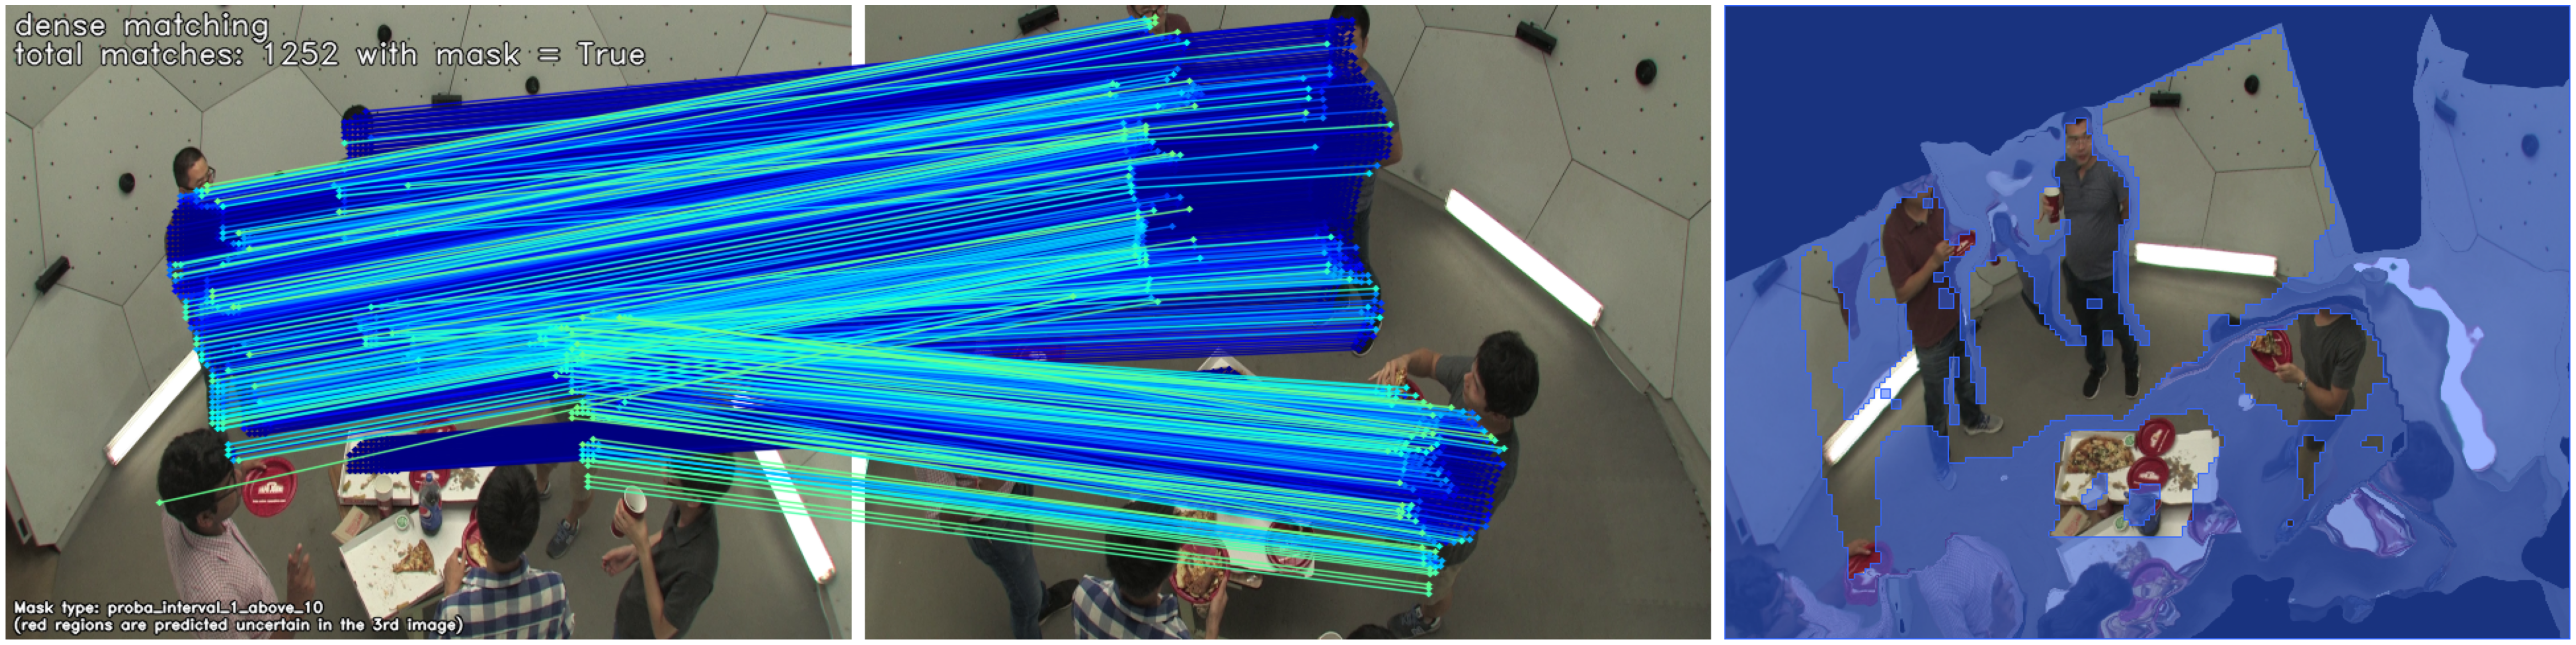

(1252, 2)


In [8]:
img0 = frame_set0[8]
img1 = frame_set1[3]

dm = denseMatching()
mkpts0,mkpts1,mconf = dm.get_matches_and_confidence(img0,img1,0.29)
dm.visualize_matches(mask = True)
mask_bg = maskBg(img0)
mask_idx = MaskIndex(mkpts0,mask_bg)
#Background removal
_,mkpts0,mkpts1,mconf = bgRemoval(mkpts0,mkpts1,mconf,mask_idx)
print(mkpts1.shape)

## fundamental matrix and visualize epipolar lines

In [9]:
import torch

scale_x = 640 / 1920
scale_y = 480 / 1080
cam0 = {
    "K": torch.tensor([[1395.91 * scale_x, 0.0, 951.559 * scale_x],
                       [0.0, 1392.24 * scale_y, 561.398 * scale_y],
                       [0.0, 0.0, 1.0]]),
    "R": torch.tensor([[0.05337497606, 0.02479711619, 0.9982666052],
                       [0.6376765256, 0.7684660834, -0.05318390075],
                       [-0.7684528356, 0.6394098699, 0.0252043199]]),
    "t": torch.tensor([[6.299256813],
                       [104.397182],
                       [363.078698]])
}
cam1 = {
    "K": torch.tensor([[1633.26 * scale_x, 0.0, 949.479 * scale_x],
                       [0.0, 1629.32 * scale_y , 572.374 * scale_y],
                       [0.0, 0.0, 1.0]]),
    "R": torch.tensor([[-0.5292732399, -0.01229259603, 0.8483623811],
                       [0.636650989, 0.6551966806, 0.4066851706],
                       [-0.5608434325, 0.7553583268, -0.3389519765]]),
    "t": torch.tensor([[-5.411400695],
                       [80.12176746],
                       [379.8488129]])
}

K0, K1 = cam0["K"], cam1["K"]
R0, R1 = cam0["R"], cam1["R"]
t0, t1 = cam0["t"], cam1["t"]

E_mat = K.geometry.epipolar.essential_from_Rt(R0, t0, R1, t1)
F_mat = K.geometry.epipolar.fundamental_from_essential(E_mat, K0, K1)

print("Fundamental matrix: \n", F_mat)

def draw_epilines(image1,points,image2,Fm):
    """
    For verifing Fm.
    Draw epilines on image2 and corresponding points on image1.
    """
    lines2 = cv2.computeCorrespondEpilines(mkpts0, 1, Fm)
    lines2 = lines2.reshape(-1, 3)

    for r, pt in zip(lines2, points):
        color = tuple(np.random.randint(0, 255, 3).tolist())
        x0, y0 = map(int, [0, -r[2]/r[1]])
        x1, y1 = map(int, [image2.shape[1], -(r[2]+r[0]*image2.shape[1])/r[1]])
        image1 = cv2.circle(image1, tuple(map(int, pt)), 5, color, -1)
        image2 = cv2.line(image2, (x0, y0), (x1, y1), color, 1)
    return image1, image2

def visualize_epipolarline(image1,points,image2,Fm):
    image1_with_points, image2_with_lines = draw_epilines(image1, mkpts0[:], image2, Fm)
    plt.figure(figsize=(16,8))
    plt.subplot(121)
    plt.imshow(image1_with_points)
    plt.axis('off')
    plt.subplot(122)
    plt.imshow(image2_with_lines)
    plt.axis('off')
    plt.show()
    
# visualize_epipolarline(img0,mkpts0,img1,np.array(F_mat))

Fundamental matrix: 
 tensor([[-5.9504e-05, -6.9686e-05,  4.9947e-02],
        [-5.8388e-05,  4.1050e-05,  1.7744e-01],
        [-9.7330e-02, -1.5972e-01,  2.8025e+01]])


## 7. compute distance(or num of inliers)

In [10]:
#for each frame in video0 and video1
import time
match_frame1 = 0
min_distance = 100000
dm = denseMatching()
for j,frame0 in enumerate(frame_set0[5:]):
    start = time.time()
    mask_bg = maskBg(frame0)
    print(f"______________________________ Begin matching with 0_Frame {j+6} _________________________________")
    min_distance = 100000
    for i,frame1 in enumerate(frame_set1):
        mkpts0,mkpts1,mconf = dm.get_matches_and_confidence(frame0,frame1,conf_threshold=0.29)
        total_n_matches = dm.total_n_matches
        mask_idx = MaskIndex(mkpts0,mask_bg)
        #Background removal
        total_n_matches,mkpts0,mkpts1,mconf = bgRemoval(mkpts0,mkpts1,mconf,mask_idx)
        
        if len(mkpts0) == 0 or len(mkpts1) ==0:
            distances = 100000
        else:
            F_mat= torch.Tensor(F_mat.reshape(-1, 3, 3))
            F_mat= F_mat.to(device)
            distances = K.geometry.epipolar.sampson_epipolar_distance(torch.tensor(mkpts0).to(device), torch.tensor(mkpts1).to(device), F_mat, squared=True, eps=1e-08)
            distances = distances.mean()
        if distances < min_distance:
            min_distance = distances
            match_frame1 = i+6
        print(f"Matching distances between 0_Frame {j+6} and 1_Frame {i+6}:{distances}; in total:{total_n_matches} matched points")
    end = time.time()
    print(f" Result: 0_Frame {j+6} corresponds to 1_Frame {match_frame1} with distance {min_distance}, time cost:{end-start}")

Model: PDCNet_plus
Pre-trained-model: megadepth
GOCor: Local iter 7
GOCor: Global iter 3
______________________________ Begin matching with 0_Frame 6 _________________________________
Matching distances between 0_Frame 6 and 1_Frame 6:2.303976535797119; in total:1011 matched points
Matching distances between 0_Frame 6 and 1_Frame 7:16.782318115234375; in total:928 matched points
Matching distances between 0_Frame 6 and 1_Frame 8:39.00257873535156; in total:996 matched points
Matching distances between 0_Frame 6 and 1_Frame 9:27.135364532470703; in total:888 matched points
Matching distances between 0_Frame 6 and 1_Frame 10:14.294195175170898; in total:884 matched points
Matching distances between 0_Frame 6 and 1_Frame 11:13.20272445678711; in total:946 matched points
Matching distances between 0_Frame 6 and 1_Frame 12:8.34976577758789; in total:600 matched points
Matching distances between 0_Frame 6 and 1_Frame 13:13.675333976745605; in total:905 matched points
Matching distances betwe

In [11]:
#15，155，0.29

## Draft below

In [12]:
# # choose model 
# model = 'PDCNet_plus'
# pre_trained_model = 'megadepth'
# flipping_condition = False 
# global_optim_iter = 3
# local_optim_iter = 7 
# path_to_pre_trained_models = '/home/jireh/MT/video_sychronazation/DenseMatching/pre_trained_models' 
#     
# if model not in model_type:
#     raise ValueError('The model that you chose is not valid: {}'.format(model))
# if pre_trained_model not in pre_trained_model_types:
#     raise ValueError('The pre-trained model type that you chose is not valid: {}'.format(pre_trained_model))
# 
# # inference parameters for PDC-Net
# network_type = model  # will only use these arguments if the network_type is 'PDCNet' or 'PDCNet_plus'
# choices_for_multi_stage_types = ['d', 'h', 'ms']
# multi_stage_type = 'h'
# if multi_stage_type not in choices_for_multi_stage_types:
#     raise ValueError('The inference mode that you chose is not valid: {}'.format(multi_stage_type))
# 
# confidence_map_R =1.0
# ransac_thresh = 1.0
# mask_type = 'proba_interval_1_above_10'  # for internal homo estimation
# homography_visibility_mask = True
# scaling_factors = [0.5, 0.6, 0.88, 1, 1.33, 1.66, 2]
# compute_cyclic_consistency_error = True  # here to compare multiple uncertainty
# confident_mask_type="proba_interval_1_above_10"
# 
# # usually from argparse
# args = DotDict({'network_type': network_type, 'multi_stage_type': multi_stage_type, 'confidence_map_R': confidence_map_R, 
#                 'ransac_thresh': ransac_thresh, 'mask_type': mask_type, 
#                 'homography_visibility_mask': homography_visibility_mask, 'scaling_factors': scaling_factors, 
#                 'compute_cyclic_consistency_error': compute_cyclic_consistency_error})
# 
# network, estimate_uncertainty = select_model(
#         model, pre_trained_model, args, global_optim_iter, local_optim_iter,
#         path_to_pre_trained_models=path_to_pre_trained_models)
# 
# 
# pred = network.get_matches_and_confidence(target_img=torch.from_numpy(img0).permute(2, 0, 1)
#                                                   .unsqueeze(0), source_img=torch.from_numpy(img1).permute(2, 0, 1)
#                                                   .unsqueeze(0), confident_mask_type=confident_mask_type)
# mkpts0 = pred['kp_source']
# mkpts1 = pred['kp_target']
# mconf = pred['confidence_value']